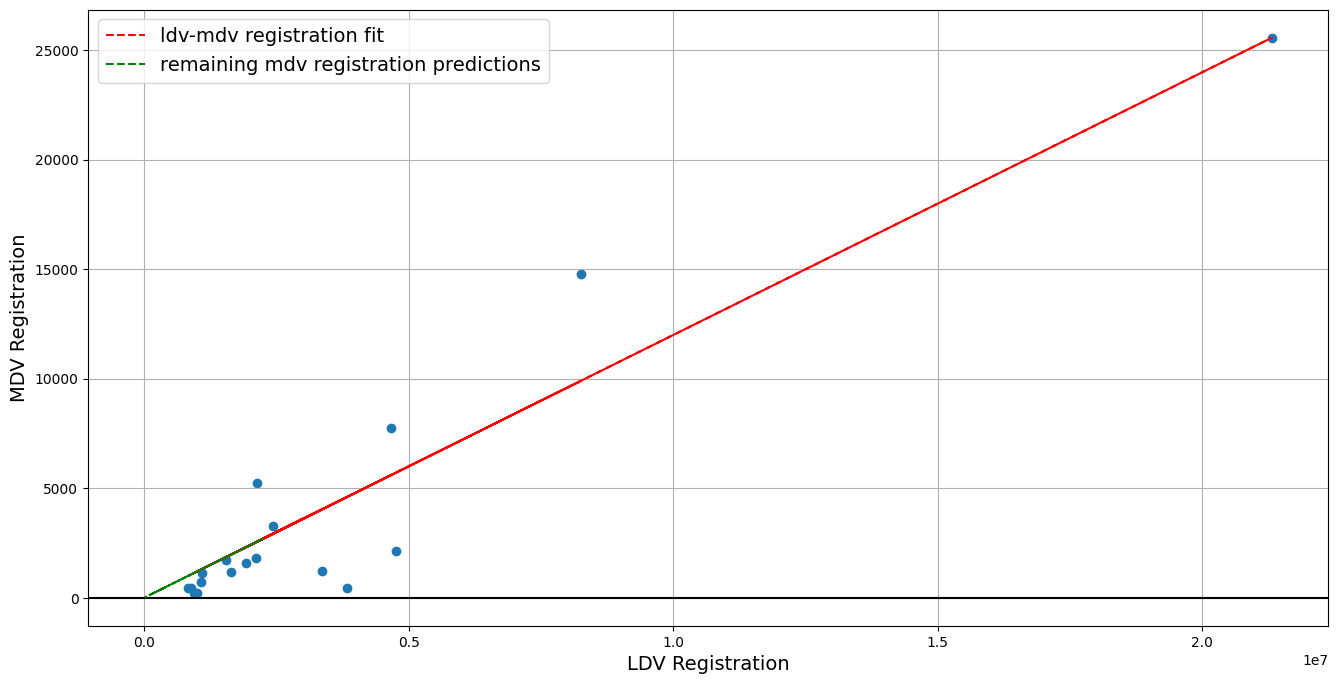

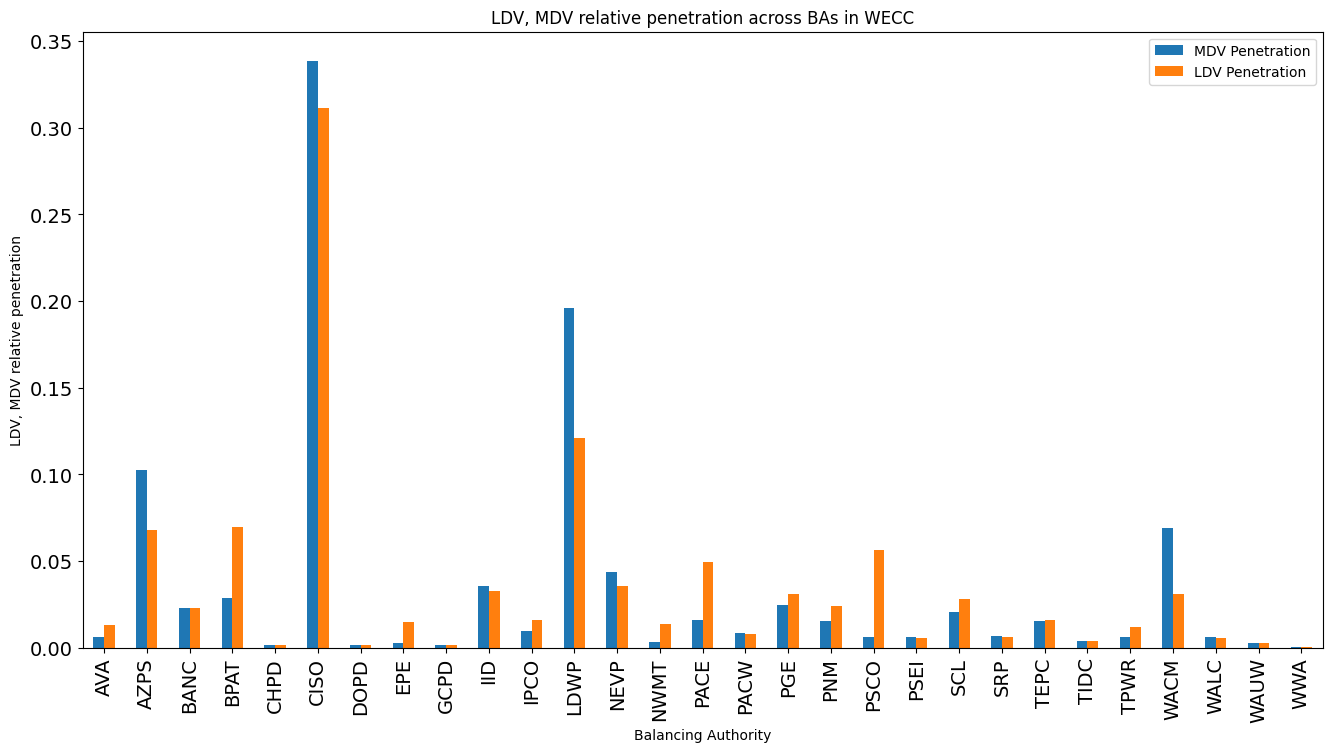

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
from sklearn.linear_model import HuberRegressor

##---Some BAs in WECC do not have MDVs. This code estimates the MDV penetration in those BAs--- 
##---using the LDV penetration. We further assume that HDVs has same penetration as MDVs---

#---Reads the file with LDV and MDV registration data.--- 

df = pd.read_csv(os.path.join('..', 'input', 'mdv_ldv_mapping.csv'))


#---BAs that have both MDV and LDV registration data.---

ba_with_mdv                            = np.array(df['Balancing Authority MDV'].dropna())
mdv_registration_in_ba_with_mdv        = np.array(df['MDV Registration'].dropna())
ldv_registration_in_ba_with_mdv        = np.array(df['LDV Registration'][df['Balancing Authority LDV'].isin(ba_with_mdv)])
mdv_penetration_in_ba_with_mdv         = mdv_registration_in_ba_with_mdv/sum(mdv_registration_in_ba_with_mdv)
ldv_penetration_in_ba_with_mdv         = ldv_registration_in_ba_with_mdv/sum(ldv_registration_in_ba_with_mdv)


#---BAs without MDV registration data---

ba_without_mdv                      = (df[~df['Balancing Authority LDV'].isin(df['Balancing Authority MDV'])]['Balancing Authority LDV'])
ldv_registration_in_ba_without_mdv  = np.array(df['LDV Registration'][df['Balancing Authority LDV'].isin(list(ba_without_mdv))])
ldv_penetration_in_ba_without_mdv   = np.array(ldv_registration_in_ba_without_mdv)/sum(ldv_registration_in_ba_without_mdv)


#---Fit a curve for MDV and LDV registrations---

model = HuberRegressor()
model.fit(ldv_registration_in_ba_with_mdv.reshape(-1, 1), mdv_registration_in_ba_with_mdv.flatten())

#---Predict MDV registrations for BAs without MDV data---

mdv_registration_in_ba_without_mdv  = model.predict(ldv_registration_in_ba_without_mdv.reshape(-1, 1))

#---Visulaize the registrations and fits---

ax, fig = plt.subplots(figsize =(16,8))
ax.fontsize = 14
plt.scatter(ldv_registration_in_ba_with_mdv, mdv_registration_in_ba_with_mdv)
plt.grid()
plt.fontsize = 14
plt.axhline(y = 0, color = 'k', linestyle = '-')
plt.xlabel('LDV Registration', fontsize = 14)
plt.ylabel('MDV Registration', fontsize = 14)

model_y1 = ldv_registration_in_ba_with_mdv*model.coef_[0] + model.intercept_

plt.plot(ldv_registration_in_ba_with_mdv, model_y1, color='red', linestyle='--', label='ldv-mdv registration fit')

model_y2 = ldv_registration_in_ba_without_mdv*model.coef_[0] + model.intercept_

plt.plot(ldv_registration_in_ba_without_mdv, model_y2, color='green',linestyle='--', label='remaining mdv registration predictions')
plt.legend(fontsize = 14)

# plot_fp  = os.path.join('..', 'input', f'ldv-mdv registration fit.png')
# plt.savefig(plot_fp, bbox_inches='tight', dpi=300)

#---Put data together---

df_final = pd.DataFrame()
df_final['Balancing Authority']  = np.append(ba_with_mdv, ba_without_mdv)
df_final['MDV Registration']     = np.append(mdv_registration_in_ba_with_mdv, mdv_registration_in_ba_without_mdv)
df_final['MDV Penetration']      = df_final['MDV Registration']  /df_final['MDV Registration'] .sum()
df_final['LDV Registration']     = np.append(ldv_registration_in_ba_with_mdv, ldv_registration_in_ba_without_mdv)
df_final['LDV Penetration']      = df_final['LDV Registration']  /df_final['LDV Registration'] .sum()
df_final                         = df_final.sort_values('Balancing Authority', ascending=True)

#---Visualize and write the penetrations in .csv---
ax = df_final.plot(x="Balancing Authority", y=["MDV Penetration", "LDV Penetration"], kind="bar",figsize =(16,8), fontsize = 14)
ax.set(ylabel='LDV, MDV relative penetration', title=f'LDV, MDV relative penetration across BAs in WECC')
plot_fp  = os.path.join('..', 'input', f'ldv-mdv penetration bar plot.png')
plt.savefig(plot_fp, bbox_inches='tight', dpi=300)
plt.show()

#---Write the penetration to .csv.----
                                        
df_final.to_csv(os.path.join('..', 'input', 'mdv_ba_percent_wecc.csv'), index=False)